In [1]:
import numpy as np
import pandas as pd
import json
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import re
import warnings
warnings.filterwarnings("ignore")

<!-- BEGIN QUESTION -->

<br><br>

---

## Data Sampling and Collection

In the following cells, We showed the code about how we deal with the original dataset. Since the orginal dataset is pretty large, we did not attach this part of data. If you want to generate from the original data, you can download the data from the link we provided, and then run this part of code. The original data is downloaded from https://nijianmo.github.io/amazon/index.html. We use the part of **Complete review data** and the specific category **Electronics**.

In [ ]:
# This part we load the original dataset.

data_meta = []
with gzip.open('meta_Electronics.json.gz') as f:
    for l in f:
        data_meta.append(json.loads(l.strip()))
        
# df_meta is the dataframe with all products information
df_meta = pd.DataFrame.from_dict(data_meta)

data_review = []
with gzip.open('Electronics.json.gz') as f:
    for l in f:
        data_review.append(json.loads(l.strip()))
        
# df_review is the dataframe with all reviews information
df_review = pd.DataFrame.from_dict(data_review)


The following is how we generate the data we want to use. First, we dropped some duplicated rows and all rows that do not have a valid rating. Second, to make the dataset more useful, we want each user has rated a number of products and each product has several ratings. Finally, we filter the data again to make sure the review data and products data have common products. 

There might be a potential bias in the sampling process since we only keep the data whose products and users that has a number of records.

In [ ]:
# This part is data preprocessing.

# First step, we dropped some duplicated rows and all rows that do not have a valid rating. 
df_meta = df_meta.drop_duplicates('asin')
df_review = df_review.dropna(subset = ['overall'])
df_review = df_review.drop_duplicates(['asin', 'reviewerID'])
df_review = df_review[(df_review['overall']<=5) & (df_review['overall']>0)]
df_part = df_review[['overall', 'reviewerID', 'asin']]

# Second step, to make the dataset more useful, we want each user has rated a number of products 
# and each product has several ratings. 
df_part = df_part.groupby('reviewerID').filter(lambda x: len(x) > 20)
df_part = df_part.groupby('asin').filter(lambda x: len(x) > 20)
df_part = df_part.groupby('reviewerID').filter(lambda x: len(x) > 10)

# Third step, make sure the review data and products data have common products.
df_review_save = df_review.loc[df_part.index]
df_meta_save = df_meta[df_meta['asin'].isin(df_review_save.asin.unique())]
df_review_save = df_review_save[df_review_save['asin'].isin(df_meta_save.asin.unique())]

# Save the dataset we will use
df_review_save.to_csv('filter.csv')
df_meta_save.to_csv('meta.csv')



<!-- BEGIN QUESTION -->

<br><br>

---

## Loading Dataset

In this following cell, We load the dataset we will use. Note: this dataset is already been selected and cleaned to make it smaller and usable. 

$meta$ contains the information of products and $rating$ contains the information of reviews(User and product together can work as the primary key.)

In [2]:
meta   = pd.read_csv("meta.csv")
rating = pd.read_csv("filter.csv")

In [3]:
meta.head(3)

,Unnamed: 0,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,201,"['Electronics', 'Accessories &amp; Supplies', ...",NaN,['The videosecu TV mount is a mounting solutio...,NaN,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...","['B000WYVBR0', 'B003O1UYHG', 'B002YV4WJS', 'B0...",NaN,VideoSecu,"['Fits most 22"" to 47"" HDTV and some up to 55""...",['>#176 in Electronics &gt; Accessories &amp; ...,[],All Electronics,"class=""a-bordered a-horizontal-stripes a-spa...","February 25, 2007",$34.99,0972683275,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN
1,418,"['Electronics', 'Computers &amp; Accessories',...","class=""a-keyvalue prodDetTable"" role=""present...",['Sandisk SDSDQUA-064G-A11 Professional Ultra ...,NaN,Sandisk SDSDQUA-064G-A11 Professional Ultra 64...,[],"class=""a-keyvalue prodDetTable"" role=""present...",SanDisk,['Add up to 128GB to your Android tablet or sm...,"['>#3,722 in Cell Phones &amp; Accessories (Se...","['B073JYVKNX', '9973399986', '9966569863', 'B0...",Computers,"class=""a-bordered a-horizontal-stripes a-spa...","October 13, 2011",$12.99,106171327X,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN
2,463,"['Electronics', 'eBook Readers &amp; Accessori...",NaN,"[""The NOOK Simple Touch eReader allows you to ...",NaN,Barnes &amp; Noble Nook Simple Touch eBook Rea...,"['B016F1SVVM', '1616855711', 'B00KBPQHMO', '16...",NaN,Barnes &amp; Noble,"['Box Content - eReader, microUSB Cable, Start...","['>#58,105 in Electronics (See Top 100 in Elec...","['B077Y84B2C', '1400501717', 'B00L89V1AA', 'B0...",Home Audio &amp; Theater,"class=""a-bordered a-horizontal-stripes a-spa...","June 3, 2011",NaN,140053271X,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN


In [4]:
rating.head(3)

,Unnamed: 0,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,2219,5.0,True,"11 18, 2017",A39KGSKV4C7LDV,0972683275,NaN,Ken Mile-Hi,I needed a television hanger with good extensi...,Glad I bought this.,1510963200,NaN,NaN
1,2220,5.0,True,"10 31, 2017",A2Y3EXMNVOV2IO,0972683275,NaN,Chocobo Sandwich,Good quality for the price. Actually does go 2...,Good quality for the price,1509408000,NaN,['https://images-na.ssl-images-amazon.com/imag...
2,2232,5.0,True,"05 23, 2017",A3EEKCGMZ2UQUE,0972683275,NaN,Tukansam,This was easier that I thought to installed......,Mount This!,1495497600,NaN,NaN


In [5]:
rating.groupby('asin').size().sort_values()

asin
B0007GBB0K      11
B01D4H1BOE      12
B000JO3N3S      13
B0013MV7FQ      13
B00ASC3PJ8      13
              ... 
B000FNFSPY    1148
B0019EHU8G    1153
B0019HL8Q8    1192
B00M55C0NS    1276
B003L1ZYYW    1735
Length: 12980, dtype: int64

In [6]:
rating.groupby('reviewerID').size().sort_values()

reviewerID
A3CXANJM0YYI84     10
A1D0JL1XVA0BY2     10
A39NGYK97FBZM3     10
A53AFLXSJWMHI      10
AB7DR7FWLMGZ9      10
                 ... 
ANGGNFE8DXGYC     201
ADLVFFE4VBT8      204
A31N0XY2UTB25C    208
A1EXGL6L0QQ0M5    232
A680RUE1FDO8B     304
Length: 36371, dtype: int64


<!-- BEGIN QUESTION -->

<br><br>

---

## Data Preprocessing and Exploratory Data Analysis (EDA)

In the following cells, We clean the data further and do some EDA.

### EDA on distribution of products

In the following part, we focus on the $meta$ dataframe and explore some top brands of the products. At the same time, we take a look at their price distributions.

In [7]:
# reformat the price, create a column for price float value 
def my_price(s):
    return re.match(r'^\$([0-9]*,)*[0-9]+\.[0-9]+$', s) != None

def my_clean_price(df_in):
    df = df_in.copy()
    return df[df['price'].apply(my_price)]

def f(s):
    tmp = s.replace(',', '')
    return float(tmp[1:])

df = meta.dropna(subset = ["price"])
df = my_clean_price(df)
df['price float'] = df['price'].apply(f)

In [8]:
# Find top brands in the products
top_brands = df["brand"].value_counts()
top_brands = top_brands[:10]
top_df = df[df["brand"].isin(top_brands.index)]
top_df = top_df[top_df["price float"]<100 ]

In [9]:
# Plot the top brands and their price distribution
def plot_brands(df):
    
    fig, axs = plt.subplots(nrows=2, figsize=(12,8),  dpi= 100)
    sns.boxplot(
        x='brand',
        y='price float',
        data=df,
         ax=axs[0], order = df["brand"].value_counts().index
    )

    sns.countplot(
        x='brand',
        data=df,
        ax=axs[1], order = df["brand"].value_counts().index
    )

    axs[0].axhline(
        y=df['price float'].median(), 
        color='red',
        linestyle='dotted'
    )

    plt.xlabel("Brand")
    plt.subplots_adjust(hspace=0.01)
#     plt.show()
    plt.savefig("brand.png")

# Plot the top brands and their main categories.
def plot_main_cat(df, name):
    
    fig = plt.figure(figsize=(12,8), dpi= 100)

    df_b = df[df["brand"].isin(name)]
    df_b = df_b[df_b["main_cat"].isin(df_b["main_cat"].value_counts().index[:4])]

    sns.countplot(
        x='main_cat',
        data=df_b, hue = "brand",
        order = df_b["main_cat"].value_counts().index
    )

    plt.xlabel("Main category")
    plt.ylabel("Count")
    plt.title("Count for top 4 main categories of top 4 brands. ")
    plt.subplots_adjust(hspace=0.01)
    plt.savefig("count_main_cat.png")
#     plt.show()

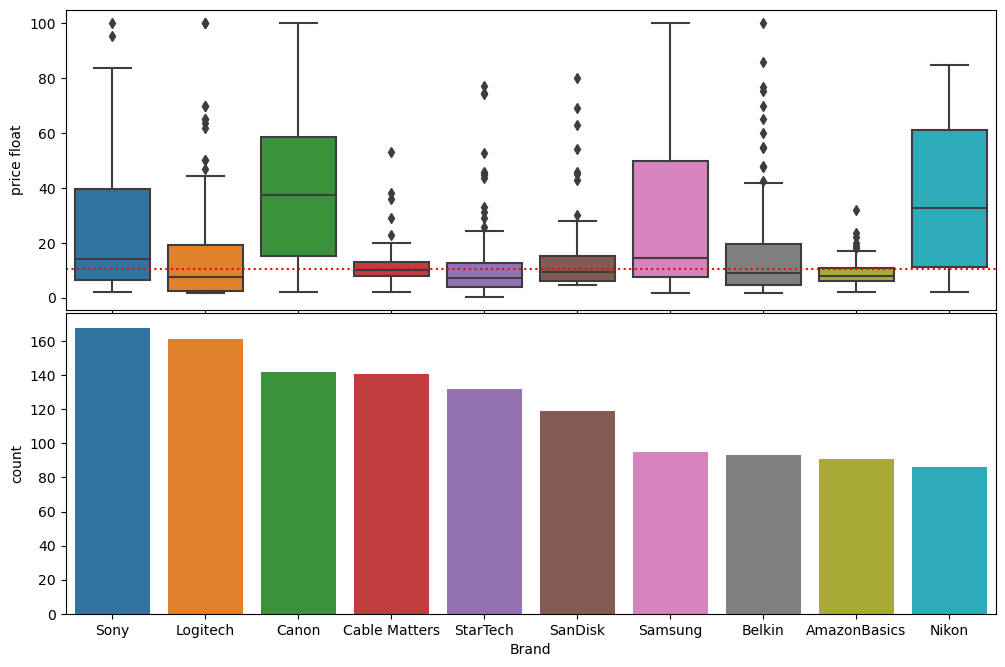

In [10]:
plot_brands(top_df)

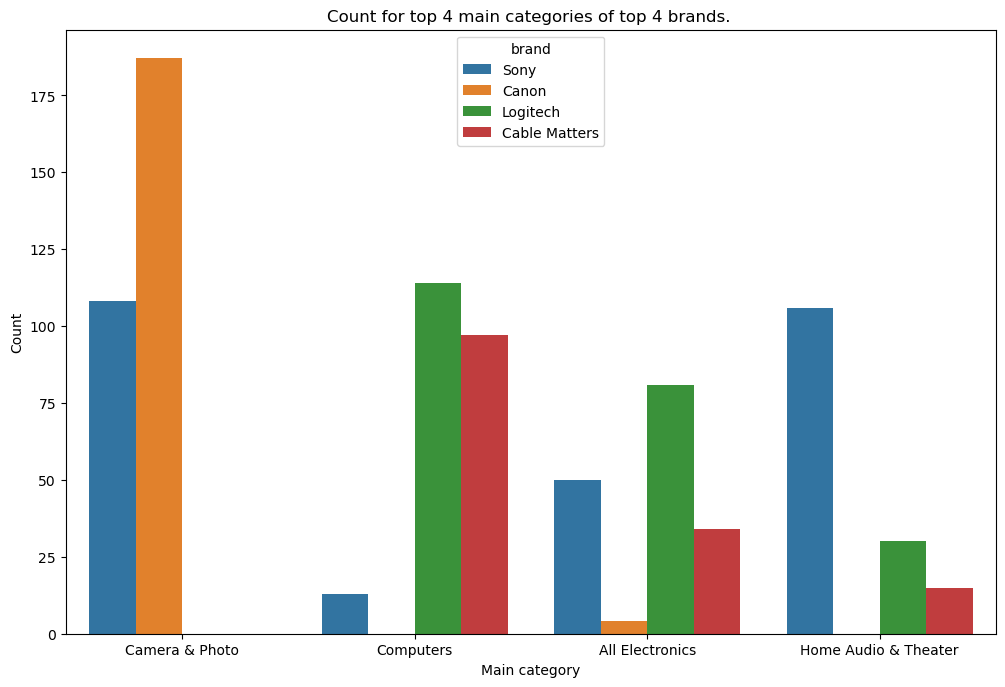

In [11]:
plot_main_cat(meta, top_brands.index[:4])

### EDA on distribution of rating
In the following part, we focus on the $rating$ dataframe and plot some distribution of the ratings.

In [12]:
df_rating=pd.DataFrame(
    {'Number of Rating':rating.groupby('asin').count()['overall'], 
     'Mean Rating':rating.groupby('asin').mean()['overall']})

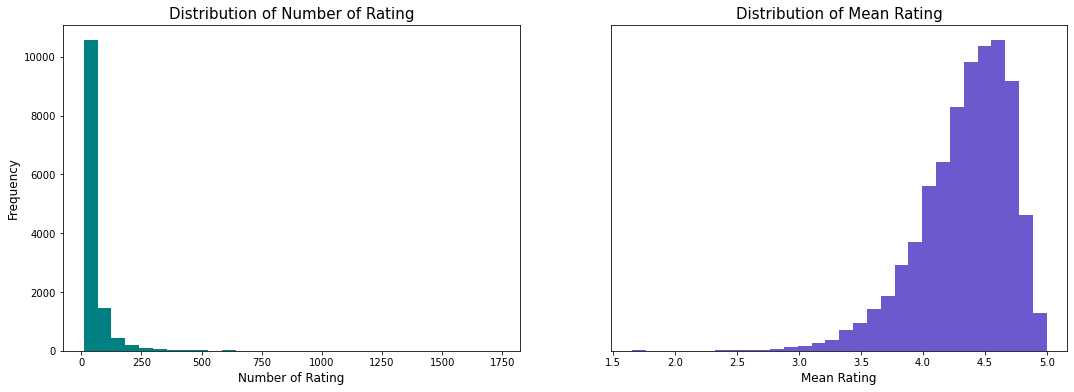

In [13]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.hist(x='Number of Rating',data=df_rating,bins=30,color='teal')
plt.title('Distribution of Number of Rating', fontsize=15)
plt.xlabel('Number of Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1,2,2)
plt.hist(x='Mean Rating',data=df_rating,bins=30, color='slateblue')
plt.title('Distribution of Mean Rating', fontsize=15)
plt.xlabel('Mean Rating', fontsize=12)
plt.yticks([])
# plt.show()
plt.savefig("rating_distr.png")

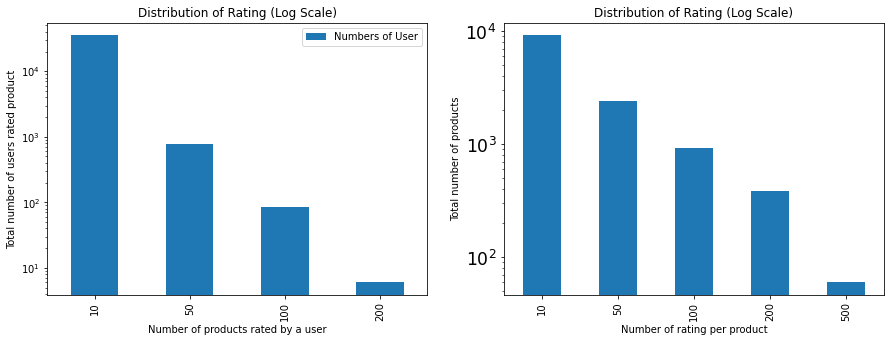

In [14]:
rating_by_user = rating.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)
rating_by_product = rating.groupby("asin").agg({"reviewerID":"count","overall":"mean"}).rename(
                        columns={"reviewerID":"Number of Ratings", "overall":"Average Rating"}).reset_index()
rating_hist,  bins  = np.histogram(rating_by_user, bins=[10,50,100,200, 400])
rating_hist2,  bins2  = np.histogram(rating_by_product["Number of Ratings"], bins=[10,50,100,200,500,1000,])

figsize = (15,5)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=figsize)

pd.DataFrame({"Numbers of User":rating_hist,"Total Rates":bins[:-1]}).plot.bar(x="Total Rates", ax=ax1)
ax1.set(yscale="log")
ax1.set(ylabel="Total number of users rated product", xlabel="Number of products rated by a user")
ax1.set(title="Distribution of Rating (Log Scale)")

pd.DataFrame({"Numbers of Products":rating_hist2,"Total Rates":bins2[:-1]}).plot.bar(x="Total Rates", ax=ax2)
ax2.set(yscale="log")
ax2.set(ylabel="Total number of products", xlabel="Number of rating per product")
ax2.set(title="Distribution of Rating (Log Scale)")
ax2.get_legend().remove()
[item.set_fontsize("xx-large") for item in ax2.get_yticklabels()]
# plt.show()
plt.savefig("rate_by_up.png")


<!-- BEGIN QUESTION -->

<br><br>

---

## Recommender construction

The following part is our model construction. We can work on the recommender system. Previous work include some recommendation systems like: Popularity Based Recommendation and Collaberative filtering. In our work, we decide to use the **Collaberative filtering** which can use more information.

### Collaborative Filtering

Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. 

In collaborative filtering, we model the rating as an inner product of the product and user feature vectors given by
\begin{equation}
    \hat{R}_{ij} = x_i^{\rm T}\theta_j
\end{equation}

Building up the recommender system boils down to an optimization problem where our objective function is
\begin{equation}
    l = \sum_{(i, j)\in D} (R_{ij} - x_i^{\rm T}\theta_j)^2
\end{equation}
and our task is to minimize our objective function $l$.



In [ ]:
# Install the surprise package if you haven't
# !pip install scikit-surprise

In [15]:
from surprise import Reader, Dataset 
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

#### Exploration of Different Algorithms for Recommender Systems
Surprise has a few different algorithms built in. In the following cells, we tested different algorithms for the recommender system. 

The algorithms include: SVD(), SVDpp(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering().

In [16]:
reader = Reader()
data = Dataset.load_from_df(rating[['reviewerID', 'asin', 'overall']], reader)

In [18]:
benchmark = []
# Iterate over all algorithms

algorithms = [SVD(), SVDpp(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    # results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x2a33c9610>, <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x2a321cfa0>, <surprise.prediction_algorithms.knns.KNNBaseline object at 0x2a321cb80>, <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x2a321c9a0>, <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x2a321ccd0>, <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x2a31e1fd0>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x2a33c9610>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x2a33c9610> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x2a321cfa0>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x2a321cfa0> 


Starting:  <surprise.prediction_algorithms.knns.KNNBaseline object at 0x2a321cb80>
Estimating biases using als...
Computing the msd similar

In [19]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [20]:
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.970735,6.673404,3.826402
SVD,0.972813,4.300249,1.258878
BaselineOnly,0.973288,0.836133,1.145310
CoClustering,1.016629,6.574701,1.160980
KNNWithMeans,1.067689,64.801745,23.355690
KNNBaseline,1.073937,64.720593,23.611508


#### Cross-Validation for Hyperparameters
From previous results, we decide the use the SVD() algorithms. In the following part, we want to find the best hyperparameters using Cross-Validation.

**Exploration for n_factors**

In [31]:
np.random.seed(2)
param_grid = {
    "n_factors": [1, 3, 4, 5, 6, 7, 10, 20, 30 ],
    "n_epochs": [20],
    "lr_all": [0.005],
    "reg_all": [0.02]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], refit=True, cv=5)

gs.fit(data)

training_parameters = gs.best_params["rmse"]

In [32]:
gs.cv_results['mean_test_rmse']

array([0.96058509, 0.96057967, 0.96056946, 0.96079   , 0.96047175,
       0.96059517, 0.9606209 , 0.96106811, 0.96183411])

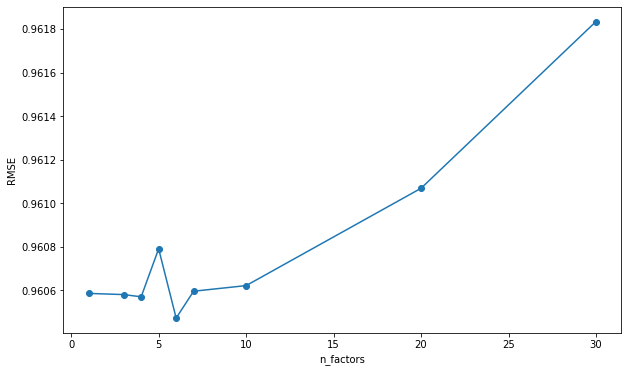

In [40]:
n_fac = [1, 3, 4, 5, 6, 7, 10, 20, 30 ]
rmse = gs.cv_results['mean_test_rmse']
plt.figure(figsize=(10, 6))
plt.plot(n_fac, rmse, '-o')
plt.ylabel("RMSE")
plt.xlabel("n_factors")
# plt.show()
plt.savefig("n_factors")

**Exploration for reg_all**

In [37]:
np.random.seed(2)
param_grid2 = {
    "n_factors": [5],
    "n_epochs": [20],
    "lr_all": [0.005],
    "reg_all": [0.005, 0.01, 0.015, 0.02,0.025, 0.03,0.035, 0.04]
}
gs2 = GridSearchCV(SVD, param_grid2, measures=["rmse", "mae"], refit=True, cv=5)

gs2.fit(data)

training_parameters2 = gs2.best_params["rmse"]


In [38]:
gs2.cv_results['mean_test_rmse']

array([0.96066799, 0.96064134, 0.96051996, 0.96046755, 0.9605321 ,
       0.96055129, 0.96047404, 0.96053893])

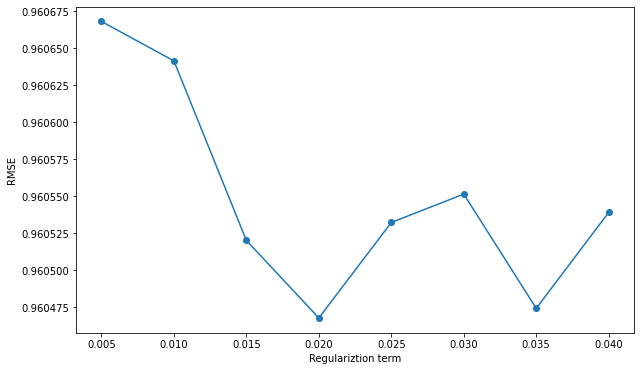

In [41]:
reg_all = [0.005, 0.01, 0.015, 0.02,0.025, 0.03,0.035, 0.04]
rmse = gs2.cv_results['mean_test_rmse']
plt.figure(figsize=(10, 6))
plt.plot(reg_all, rmse, '-o')
plt.ylabel("RMSE")
plt.xlabel("Regulariztion term")
# plt.show()
plt.savefig("reg.png")

**Exploration for n_epochs and lr_all**

In [42]:
np.random.seed(2)
param_grid2 = {
    "n_factors": [6],
    "n_epochs": [10, 20],
    "lr_all": [0.002, 0.005, 0.01],
    "reg_all": [0.02]
}
gs3 = GridSearchCV(SVD, param_grid2, measures=["rmse", "mae"], refit=True, cv=5)

gs3.fit(data)

training_parameters3 = gs3.best_params["rmse"]

In [43]:
training_parameters3

{'n_factors': 6, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}

#### Model training using best hyperparamaters

In the following part, we use the best paramters to train our model.

In [44]:
from pprint import pprint as pp
def predicting(model_f, user, item):
    uid = str(user)
    iid = str(item) 
    loaded_model = load_model(model_f)
    prediction = loaded_model.predict(user, item, verbose=True)
    rating = prediction.est
    details = prediction.details
    uid = prediction.uid
    iid = prediction.iid
    true = prediction.r_ui
    ret = {
        'user': user, 
        'item': item, 
        'rating': rating, 
        'details': details,
        'uid': uid,
        'iid': iid,
        'true': true
        }
    pp (ret)
    print ('\n\n')
    return ret

In [45]:
from collections import defaultdict

# Function to find top n ratings
def get_top_n(predictions, n=8):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n



In [46]:
# Load data using Dataset
reader = Reader()
data = Dataset.load_from_df(rating[['reviewerID', 'asin', 'overall']], reader)

# Create trainset using the full data
trainset = data.build_full_trainset()

# Build a set we can use to present our final recommendations.
x, testset = train_test_split(data, test_size=.75)

# Model Built using SVD()
algo = SVD(n_epochs = 20, lr_all = 0.05, reg_all = 0.02, n_factors = 6)
# Fit the Model
algo.fit(trainset)

# Generate all predictions for the set we generated before.
predictions = algo.test(testset)

# Get top N rating for each user in our dataset.
top_n = get_top_n(predictions, n=8)


### Serving Recommendations

Here we shows how our recommender system can be used. You can choose a user in our dataset, and use top_n to get the top_n recommendations.

In [55]:
# Print the recommended items for each user
def top_k_recommendation(User, k = 8):
    top_n = get_top_n(predictions, n=k)
    print("ProductID,  Rating")
    for a in top_n[User]:
        print(a[0]+", %1.2f" % a[1])
UserID = "A0220159ZRNBTRKLG08H"
top_k_recommendation(UserID)

ProductID,  Rating
B005G8CPDG, 5.00
B005DLDO4U, 5.00
B00JQTO8TU, 5.00
B003L1ZYYW, 5.00
B00N9BQ9ES, 5.00
B01CM85C0K, 5.00
B00K73NSU4, 4.96
B002TF0ZDQ, 4.93


### kNN regression: Similarity Chosen and Results
Given dimension $p$ of the feature vector, the collaborative filtering method could automatically learn the feature vectors. However, one downside of this method is that it does not explicitly utilize other information of the system beyond users' rating, for example, description of the product, category of the product, price, reviews, and etc.

kNN regression is a model trying to fix the above issues. In this model, the predicted rating is essentially given by the $k$-nearest-similarity-weighted average as discussed in the following.

Suppose $s(m, n)$ characterizes the similarity between product $m$ and $n$ which does not depend on user. The higher $s$ is, the closer the two products are. For product $i$ and user $j$, let us denote $K(i, j)$ as the set containing the $k$ products that have the highest similarity with product $i$ and have been rated by the user, then the prediction is given by

\begin{equation}
    \hat{R}_{ij} = \frac{\sum_{k\in K(i, j)}s(i, k)R_{kj}}{\sum_{k\in K(i, j)}s(i, k)}
\end{equation}


One example of a similarity function is given by
\begin{equation}
    s(m, n) = \frac{x_{m}^{\rm T}x_n}{||x_{m}||_2||x_{n}||_2}
\end{equation}
where $x_m$ and $x_n$ are the product feature vectors as defined in the previous subsection.

Under this choice, the problem boils down to construct a good representation of the product feature vector.


In [50]:
from sklearn.feature_extraction.text import CountVectorizer

def word_filter(content):
    words = content.split()
    words = [f'{word}' for word in words if len(word) > 3]
    return str(words)

def get_X(content):
    vectorizer = CountVectorizer()
    corpus = content.apply(word_filter)
    X = vectorizer.fit_transform(corpus)
    return X.toarray()

X_category = get_X(meta.category)
X_title = get_X(meta.title)
X_description = get_X(meta.description)


def cosine(a1, a2):
    return sum(a1 * a2) / (np.sqrt(sum(a1 * a1) * sum(a2 * a2)) + 1e-5)

# Similarity calculation
def similarity(data, pid1, pid2):

    ind1 = data[data.asin == pid1].index[0]
    ind2 = data[data.asin == pid2].index[0]

    vec1_category = X_category[ind1]
    vec2_category = X_category[ind2]
    cos_category = cosine(vec1_category, vec2_category)

    vec1_title = X_title[ind1]
    vec2_title = X_title[ind2]
    cos_title = cosine(vec1_title, vec2_title)

    vec1_description = X_description[ind1]
    vec2_description = X_description[ind2]
    cos_description = cosine(vec1_description, vec2_description)

    sim = cos_title + cos_category + cos_description

    if pid1 in data.loc[ind2, 'also_buy'] or pid2 in data.loc[ind1, 'also_buy']:
        sim += 1
    if pid1 in data.loc[ind2, 'also_view'] or pid2 in data.loc[ind1, 'also_view']:
        sim += 1

    return sim

# Return a dataframe containing the all products the user rated and their similarities with the given product.
def get_Nui(df, df2, user, item, k = 5):
    
    products = df[df['reviewerID'] == user]['asin']
    products = products[products!=item]
    sim = pd.DataFrame({'asin': products, 'sim': [similarity(df2, item, k) for k in products]})
    sort_sim = sim.sort_values(by='sim', ascending = False).head(k)
    
    return sort_sim

# Return the predicted rating given a user and product.
def predict_rating(df, df2, user, item):
    
    Nui = get_Nui(df, df2, user, item).sort_values(by = 'asin')
    sum_abs = sum([abs(a) for a in Nui['sim']])

    rs = df[df['reviewerID']==user]
    rs = rs[rs['asin'].isin(Nui['asin'])][['overall', 'asin']]
    rs = rs.sort_values(by = 'asin')
    weight_sum = np.sum(rs['overall'].values * Nui['sim'].values)

    return weight_sum/sum_abs
    
def loss_f(df, df2, size=100):
    l = 0
    np.random.seed(33)
    sample_list = np.random.choice(range(len(df)), size=size, replace=False)

    for m in tqdm(sample_list):
        l += (df['overall'].iloc[m] - predict_rating(df, df2, df['reviewerID'].iloc[m], df['asin'].iloc[m]))**2
    return np.sqrt(l / len(sample_list))

In [51]:
loss_f(rating, meta, 1000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:34<00:00,  3.64it/s]


0.9995623990850291